In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기
- 스쿨존 사고 : accident
- 안전시설물

In [29]:
# 스쿨존 좌표 데이터 불러오기
school_zone    = pd.read_csv('./어린이보호구역_전처리1.csv', encoding='utf-8-sig')

In [30]:
# 스쿨존 사고 데이터 불러오기
accident = pd.read_csv('./스쿨존 사고 데이터 전처리/성남시전체_스쿨존_사고_전처리 - 성남시_스쿨존_반경300m_최종_전처리.csv')

In [31]:
# 안전시설물 데이터 불러오기
base_path = './안전시설물 전처리/'
road_sign      = pd.read_csv(base_path + '도로안전표지_전처리1.csv', encoding='utf-8-sig')
red_surface    = pd.read_csv(base_path + '도로적색표면_전처리1.csv', encoding='utf-8-sig')
fence          = pd.read_csv(base_path + '무단횡단방지펜스_전처리1.csv', encoding='utf-8-sig')
speed_cam      = pd.read_csv(base_path + '무인교통단속카메라_전처리1.csv', encoding='utf-8-sig')
zone_sign      = pd.read_csv(base_path + '보호구역표지판_전처리1.csv', encoding='utf-8-sig')
cctv           = pd.read_csv(base_path + '생활안전CCTV_전처리1.csv', encoding='utf-8-sig')
signal         = pd.read_csv(base_path + '신호등_전처리1.csv', encoding='utf-8-sig')
yellow_carpet  = pd.read_csv(base_path + '옐로카펫_전처리1.csv', encoding='utf-8-sig')
crosswalk      = pd.read_csv(base_path + '횡단보도_전처리1.csv', encoding='utf-8-sig')

In [32]:
# 외부 안전 위험 요소 불러오기
shelter = pd.read_csv('./외부안전위험요소/성남시_아동안전지킴이집현황_전처리.csv')
lamp = pd.read_csv('../Raw-Data/외부 안전위험요소/raw_data/경기도 성남시_도로상 조명시설 지오태깅 데이터_20221216.csv', encoding='cp949')

### 함수 정의

In [10]:
# 1. 두 좌표 간 거리 계산 함수
import glob
import os

def haversine_m(lat1, lon1, lat2, lon2):
    """
    두 좌표 사이의 거리를 미터(m) 단위로 반환.
    지구를 구체로 가정하는 Haversine 공식 사용.
    """
    R = 6371000  # 지구 반경 (미터)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

### 데이터 프레임 통합
- 기준은 어린이보호구역_전처리1.csv를 기준으로 함(사고 데이터의 학교를 기준으로 하면 없는 데이터가 많음)
- result_df

#### 1) 안전시설물 개수 카운트

In [ ]:
# 각 변수를 리스트로 묶어서 한 번에 concat
facilities = pd.concat([
    road_sign, red_surface, fence, speed_cam,
    zone_sign, cctv, signal, yellow_carpet, crosswalk
], ignore_index=True)

# 결과: 시설물명 / 위도 / 경도 / 카테고리 컬럼 통합
print(facilities['카테고리'].value_counts())  # 카테고리별 개수 확인
print(f"총 시설물 수: {len(facilities)}")

카테고리
생활안전CCTV     3023
무단횡단방지펜스     1569
보호구역표지판      1343
신호등           904
도로적색표면        878
도로안전표지        695
횡단보도          691
무인교통단속카메라     310
옐로카펫           85
Name: count, dtype: int64
총 시설물 수: 9498


In [13]:
facilities.sample(5)

,시설물명,위도,경도,카테고리
5803,CCTV_중원성남-A-21,37.430907,127.127691,생활안전CCTV
9044,횡단보도_중원-100,37.414154,127.154815,횡단보도
7331,CCTV_분당판교-A-48,37.397327,127.097804,생활안전CCTV
9321,횡단보도_분당-241,37.386536,127.121227,횡단보도
5544,CCTV_수정위례-A-15,37.468500,127.138000,생활안전CCTV


In [14]:
school_zone.sample(5)

,시설물명,위도,경도,카테고리
125,성남생명숲어린이집,37.371025,127.115253,어린이보호구역
65,불곡초등학교,37.340984,127.119730,어린이보호구역
132,구미동어린이집,37.344538,127.112319,어린이보호구역
27,성남제일초등학교,37.438906,127.149609,어린이보호구역
51,이매초등학교,37.397210,127.126493,어린이보호구역


In [36]:
# 스쿨존별로 300m 이내 시설물 개수 카운트

RADIUS = 300  # 미터
categories = facilities['카테고리'].unique()

results = []

for _, school in school_zone.iterrows():
    # 해당 학교와 모든 시설물 간 거리 벡터 계산
    distances = haversine_m(
        school['위도'], school['경도'],
        facilities['위도'].values,
        facilities['경도'].values
    )
    
    # 300m 이내 시설물만 필터
    nearby = facilities[distances <= RADIUS]
    
    # 카테고리별 카운트
    counts = nearby['카테고리'].value_counts()
    
    row = {'시설물명': school['시설물명'], '위도': school['위도'], '경도': school['경도']}
    for cat in categories:
        row[cat] = counts.get(cat, 0)
    
    results.append(row)

result_df = pd.DataFrame(results)
result_df

,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,옐로카펫,횡단보도
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,1,0
1,하원초등학교,37.446255,127.170236,6,7,21,2,15,16,10,2,6
2,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,1,2
3,상대원초등학교,37.442382,127.181591,2,8,30,1,21,5,3,1,2
4,도촌초등학교,37.414730,127.158024,5,9,26,1,10,6,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
137,성남혜은학교,37.450396,127.153922,5,21,18,5,24,26,7,3,6
138,성은특수학교,37.409122,127.143952,4,6,13,0,14,10,4,0,4
139,서울국제학교,37.465792,127.128438,1,4,6,1,8,16,1,0,1
140,케이디엘피어학원,37.389127,127.124549,7,7,16,2,15,11,10,0,9


In [37]:
# 스쿨존 시설물 카운트 결과 저장
result_df.to_csv('./스쿨존_시설물_300m_카운트.csv', index=False)

In [12]:
# 스쿨존_시설물_300m_카운트.csv 파일 불러오기
result_df = pd.read_csv('./스쿨존_시설물_300m_카운트.csv')

#### 2) 사고 데이터 통합
    1. 사고 데이터의 학교와 어린이보호구역 파일의 학교랑 매칭하기

In [33]:
# 사고 데이터 통합?
# accident의 학교명 unique 추출
accident_schools = set(accident['대상시설명'].unique())

# result_df의 학교명 unique 추출
result_schools = set(result_df['시설물명'].unique())

# 일치 / 불일치 확인
matched     = accident_schools & result_schools       # 교집합
only_acc    = accident_schools - result_schools       # accident에만 있음
only_result = result_schools - accident_schools       # result_df에만 있음

print(f"총 accident 학교 수  : {len(accident_schools)}")
print(f"총 result_df 학교 수 : {len(result_schools)}")
print(f"일치하는 학교 수      : {len(matched)}")
print(f"accident에만 있는 수 : {len(only_acc)}")
print(f"result_df에만 있는 수: {len(only_result)}")


총 accident 학교 수  : 60
총 result_df 학교 수 : 142
일치하는 학교 수      : 60
accident에만 있는 수 : 0
result_df에만 있는 수: 82


In [34]:
accident.columns

Index(['대상시설명', '소재지지번주소', '위도_스쿨존', '경도_스쿨존', '사고지역위치명', '사고유형구분', '사고년도',
       '위도_사고', '경도_사고', '발생건수', '사상자수', '사망자수', '중상자수', '경상자수', '부상자수',
       '직선거리(m)'],
      dtype='object')

In [35]:
# 학교 이름 말고 위도/경도로 비교해보기
# accident의 학교 좌표 unique 추출
accident_schools = accident[['대상시설명', '위도_스쿨존', '경도_스쿨존']].drop_duplicates(subset='대상시설명')
result_schools   = result_df[['시설물명', '위도', '경도']]

RADIUS = 50 # 같은 학교로 볼 거리 기준 (미터)

matched_pairs = []

for _, acc in accident_schools.iterrows():
    distances = haversine_m(
        acc['위도_스쿨존'], acc['경도_스쿨존'],
        result_schools['위도'].values,
        result_schools['경도'].values
    )
    min_dist  = distances.min()
    min_idx   = distances.argmin()

    if min_dist <= RADIUS:
        matched_pairs.append({
            'accident_명': acc['대상시설명'],
            'result_명'  : result_schools.iloc[min_idx]['시설물명'],
            '거리(m)'    : round(min_dist, 1)
        })

matched_df = pd.DataFrame(matched_pairs)

print(f"좌표 기준 매칭된 학교 수: {len(matched_df)}")
print(f"매칭 안 된 학교 수      : {len(accident_schools) - len(matched_df)}")
matched_df

좌표 기준 매칭된 학교 수: 60
매칭 안 된 학교 수      : 0


,accident_명,result_명,거리(m)
0,구미초등학교,구미초등학교,0.0
1,금광2동제2어린이집,금광2동제2어린이집,0.0
2,금빛초등학교,금빛초등학교,0.0
3,금상초등학교,금상초등학교,0.0
4,꾸러기유치원,꾸러기유치원,0.0
5,늘사랑어린이집,늘사랑어린이집,0.0
6,다솜유치원,다솜유치원,0.0
7,단남초등학교,단남초등학교,0.0
8,단대초등학교,단대초등학교,0.0
9,대원초등학교,대원초등학교,0.0


In [36]:
# acccident에만 있는 학교를 기준으로 통합
accident.drop(columns=['소재지지번주소','사고지역위치명', '직선거리(m)'], inplace=True)
accident.rename(columns={'대상시설명': '시설물명'}, inplace=True)
accident.head()

,시설물명,위도_스쿨존,경도_스쿨존,사고유형구분,사고년도,위도_사고,경도_사고,발생건수,사상자수,사망자수,중상자수,경상자수,부상자수
0,구미초등학교,37.337756,127.118398,보행노인사고다발지,2015,37.336623,127.116617,3,3,0,3,0,0
1,구미초등학교,37.337756,127.118398,보행노인사고다발지,2012,37.337198,127.116095,3,3,0,3,0,0
2,금광2동제2어린이집,37.448432,127.163031,보행어린이사고다발지,2015,37.448111,127.163714,3,3,0,2,1,0
3,금빛초등학교,37.447331,127.140567,보행어린이사고다발지,2016,37.448199,127.140969,2,2,1,0,1,0
4,금빛초등학교,37.447331,127.140567,보행어린이사고다발지,2020,37.448491,127.140111,3,3,0,0,3,0


방법)
1. 일단 사건, 어린이보호구역 데이터에 공통으로 존재하는 스쿨존만 가지고 통합한다
2. 어린이만 하면 일단 데이터가 너무 적어질 수도 있으니까 일단 어린이+노인 합쳐서 
3. 해당 스쿨존에서 발생한 사건수 합계 | 사상자 합계         

예) 
시설물명 | 위도 | 경도 | 발생건수 | 사망및중상자수 | 사상자 합계

In [37]:
# -----------------------------------------------
# Step 1. 좌표 기준 50m 이내 공통 학교 매핑 테이블 생성
# -----------------------------------------------
accident_schools = accident[['시설물명', '위도_스쿨존', '경도_스쿨존']].drop_duplicates(subset='시설물명')

mapping = []  # accident 학교명 → result_df 학교명 매핑

for _, acc in accident_schools.iterrows():
    distances = haversine_m(
        acc['위도_스쿨존'], acc['경도_스쿨존'],
        result_df['위도'].values,
        result_df['경도'].values
    )
    min_dist = distances.min()
    min_idx  = distances.argmin()

    if min_dist <= 50:
        mapping.append({
            'accident_명': acc['시설물명'],
            'result_명'  : result_df.iloc[min_idx]['시설물명']
        })

mapping_df = pd.DataFrame(mapping)
print(f"매핑된 공통 학교 수: {len(mapping_df)}")
print(mapping_df)

매핑된 공통 학교 수: 60
    accident_명    result_명
0       구미초등학교      구미초등학교
1   금광2동제2어린이집  금광2동제2어린이집
2       금빛초등학교      금빛초등학교
3       금상초등학교      금상초등학교
4       꾸러기유치원      꾸러기유치원
5      늘사랑어린이집     늘사랑어린이집
6        다솜유치원       다솜유치원
7       단남초등학교      단남초등학교
8       단대초등학교      단대초등학교
9       대원초등학교      대원초등학교
10      대일초등학교      대일초등학교
11      돌마초등학교      돌마초등학교
12   리플플러스어린이집   리플플러스어린이집
13       미래유치원       미래유치원
14      분당초등학교      분당초등학교
15      뽀뽀뽀유치원      뽀뽀뽀유치원
16      산성어린이집      산성어린이집
17      상원초등학교      상원초등학교
18      서현어린이집      서현어린이집
19      서현초등학교      서현초등학교
20       선경유치원       선경유치원
21     성남동초등학교     성남동초등학교
22     성남북초등학교     성남북초등학교
23    성남수정초등학교    성남수정초등학교
24      성남어린이집      성남어린이집
25    성남은행초등학교    성남은행초등학교
26    성남제일초등학교    성남제일초등학교
27    성남중앙초등학교    성남중앙초등학교
28      성남초등학교      성남초등학교
29      성남혜은학교      성남혜은학교
30      성수초등학교      성수초등학교
31       성체유치원       성체유치원
32      성현어린이집      성현어린이집
33     수내동어린이집     수내동어린이집
34      수내초등학교      수내초등학교
35      수진초등

In [38]:
# -----------------------------------------------
# Step 2. accident에 result_명 컬럼 추가 (키 통일)
# -----------------------------------------------
accident = accident.merge(mapping_df, left_on='시설물명', right_on='accident_명', how='inner')
# inner join → 매핑된 60개 학교만 남음

In [39]:
# -----------------------------------------------
# Step 3. 학교별 사고 집계 (어린이 + 노인 전체)
# -----------------------------------------------
accident_agg = accident.groupby('result_명').agg(
    발생건수    = ('발생건수', 'sum'),
    사상자수    = ('사상자수', 'sum'),
    사망자수    = ('사망자수', 'sum'),
    중상자수    = ('중상자수', 'sum'),
    경상자수    = ('경상자수', 'sum'),
).reset_index()

# 사망 + 중상 합계 컬럼 추가
accident_agg['사망및중상자수'] = accident_agg['사망자수'] + accident_agg['중상자수']

print(accident_agg.shape)
accident_agg.head()

(60, 7)


,result_명,발생건수,사상자수,사망자수,중상자수,경상자수,사망및중상자수
0,구미초등학교,6,6,0,6,0,6
1,금광2동제2어린이집,3,3,0,2,1,2
2,금빛초등학교,13,13,1,5,7,6
3,금상초등학교,4,4,0,2,1,2
4,꾸러기유치원,4,5,0,2,3,2


In [40]:
# -----------------------------------------------
# Step 4. result_df 필터링 + 사고 데이터 병합
# -----------------------------------------------
# result_df에서 공통 학교만 남기기
result_filtered = result_df[result_df['시설물명'].isin(mapping_df['result_명'])].copy()

# 사고 집계 데이터 병합
final_df = result_filtered.merge(
    accident_agg[['result_명', '발생건수', '사상자수', '사망및중상자수']],
    left_on='시설물명',
    right_on='result_명',
    how='left'
).drop(columns='result_명')

print(final_df.shape)  # (60, 기존컬럼 + 사고컬럼)
final_df.head()

(60, 15)


,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,옐로카펫,횡단보도,발생건수,사상자수,사망및중상자수
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,1,0,6,6,4
1,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,1,2,1,1,1
2,구미초등학교,37.337756,127.118398,6,17,27,1,30,5,17,1,6,6,6,6
3,돌마초등학교,37.409099,127.130378,4,7,10,2,8,14,5,1,5,7,7,7
4,분당초등학교,37.378988,127.129653,2,3,12,2,11,4,5,1,3,12,12,0


In [41]:
final_df.to_csv('./스쿨존_시설물_사고통합_60개학교.csv', index=False)

### 3) 조명 개수 통합 -> 보류

In [30]:
# 
lamp.head()
lamp.rename(columns={'위도(LATITUDE)': '위도', '경도(LONGITUDE)': '경도'}, inplace=True)
lamp.head()

,순번(NO),구분(LAMP),일련번호(SER),위도,경도
0,1,2,고기로-1,37.352327,127.082932
1,2,2,고기로-2,37.352327,127.082932
2,3,2,고기로-3,37.352327,127.082932
3,4,2,구미로-1,37.343812,127.124693
4,5,2,구미로-2,37.343812,127.124693


In [31]:
# 각 조명마다 가장 가까운 학교 찾기
def find_nearest_school(lamp_row, school_zone):
    distances = haversine_m(
        lamp_row['위도'], lamp_row['경도'],
        school_zone['위도'].values,
        school_zone['경도'].values
    )
    nearest_idx = np.argmin(distances)           # 가장 가까운 학교 인덱스
    nearest_dist = distances[nearest_idx]        # 그 거리
    nearest_name = school_zone.iloc[nearest_idx]['시설물명']  # 학교명

    # 300m 초과면 None 반환 (스쿨존 외부)
    return nearest_name if nearest_dist <= 300 else None

lamp['시설물명'] = lamp.apply(lambda row: find_nearest_school(row, school_zone), axis=1)

print(lamp['시설물명'].isna().sum(), "개는 반경 300m 내 학교 없음")
lamp.head()

16379 개는 반경 300m 내 학교 없음


,순번(NO),구분(LAMP),일련번호(SER),위도,경도,시설물명
0,1,2,고기로-1,37.352327,127.082932,None
1,2,2,고기로-2,37.352327,127.082932,None
2,3,2,고기로-3,37.352327,127.082932,None
3,4,2,구미로-1,37.343812,127.124693,None
4,5,2,구미로-2,37.343812,127.124693,None


시설물 데이터 eda

In [34]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시설물명       142 non-null    object 
 1   위도         142 non-null    float64
 2   경도         142 non-null    float64
 3   도로안전표지     142 non-null    int64  
 4   도로적색표면     142 non-null    int64  
 5   무단횡단방지펜스   142 non-null    int64  
 6   무인교통단속카메라  142 non-null    int64  
 7   보호구역표지판    142 non-null    int64  
 8   생활안전CCTV   142 non-null    int64  
 9   신호등        142 non-null    int64  
 10  옐로카펫       142 non-null    int64  
 11  횡단보도       142 non-null    int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 13.4+ KB


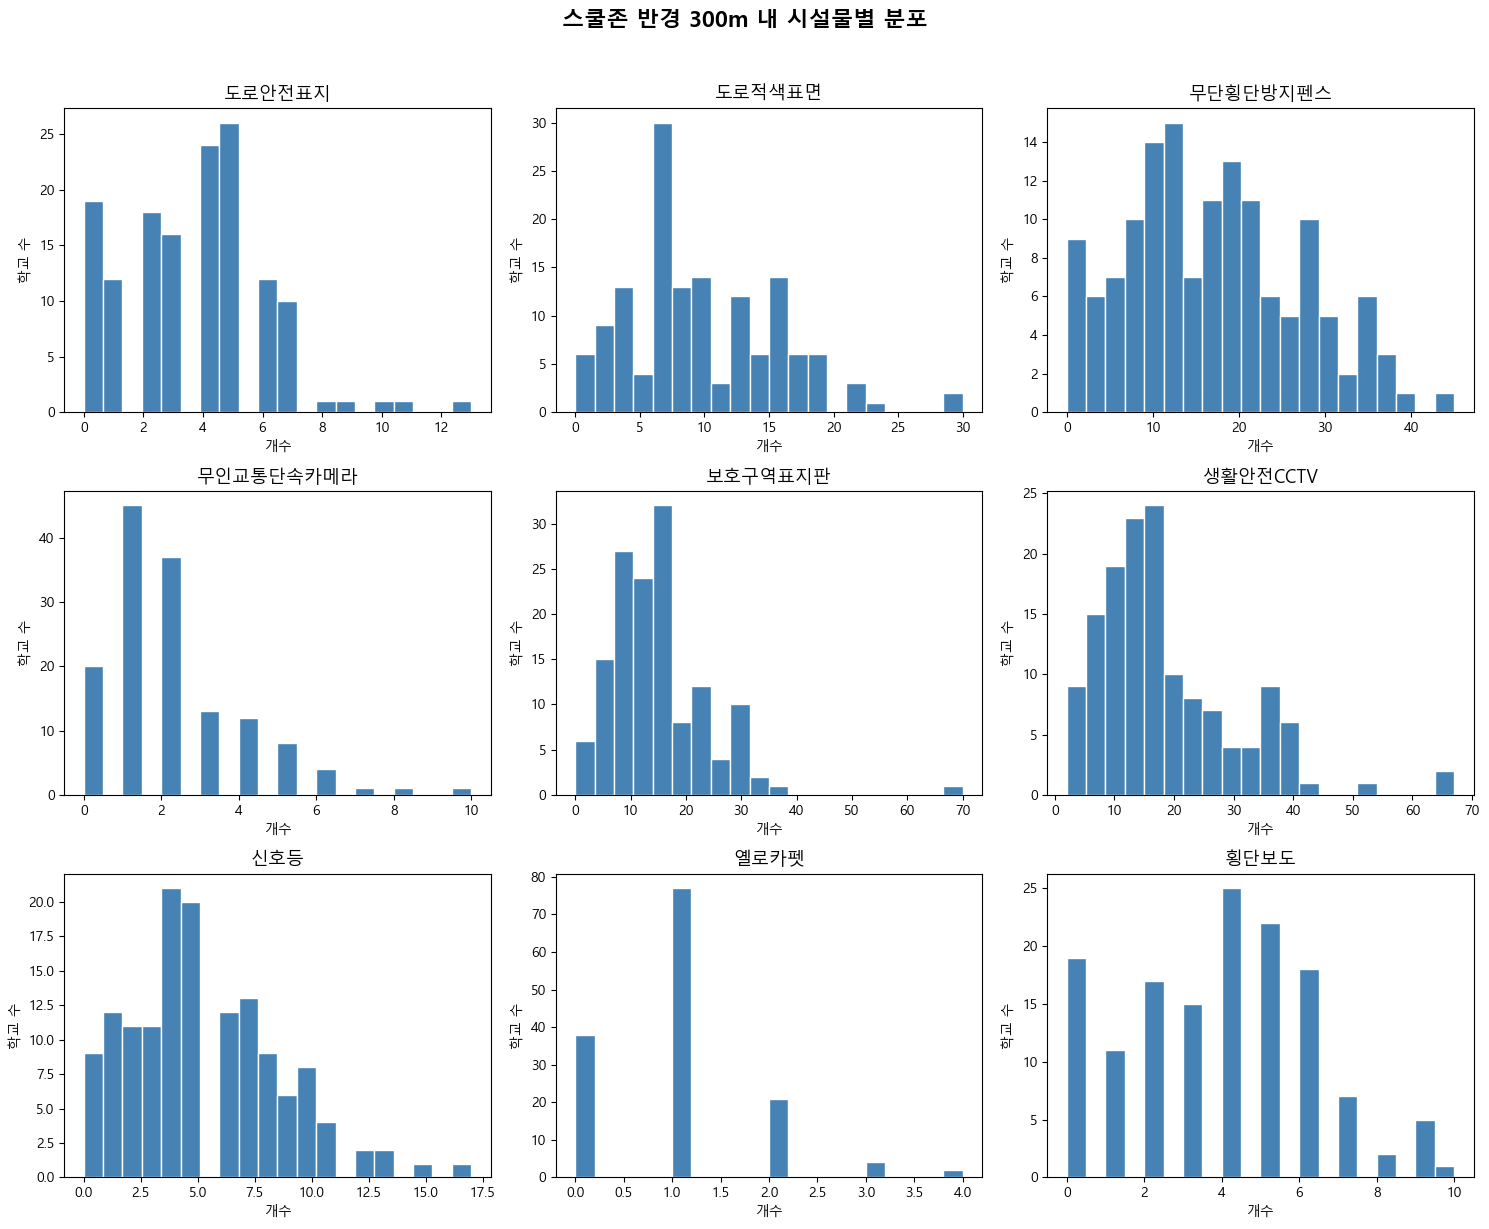

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# 시설물 컬럼만 추출
facility_cols = ['도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
                 '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(facility_cols):
    axes[i].hist(result_df[col], bins=20, color='steelblue', edgecolor='white')
    axes[i].set_title(col, fontsize=13)
    axes[i].set_xlabel('개수')
    axes[i].set_ylabel('학교 수')

plt.suptitle('스쿨존 반경 300m 내 시설물별 분포', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [27]:
accident.columns

Index(['대상시설명', '소재지지번주소', '위도_스쿨존', '경도_스쿨존', '사고지역위치명', '사고유형구분', '사고년도',
       '위도_사고', '경도_사고', '발생건수', '사상자수', '사망자수', '중상자수', '경상자수', '부상자수',
       '직선거리(m)'],
      dtype='object')

### 클로드 제안 실험

데이터 크기: (60, 15)
컬럼: ['시설물명', '위도', '경도', '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라', '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도', '발생건수', '사상자수', '사망및중상자수']

=== PCA 결과 ===
설명 분산 비율: [0.299 0.249 0.163]
총 설명 분산: 71.0%

=== K값별 실루엣 스코어 ===
  k=2: 0.2677
  k=3: 0.2843
  k=4: 0.2644
  k=5: 0.2840
  k=6: 0.3040
  k=7: 0.3078

  → Best k=7, Score=0.3078

=== 최종 클러스터링 (k=3) ===
실루엣 스코어: 0.2843

클러스터별 스쿨존 수:
cluster
0    31
1    11
2    18
Name: count, dtype: int64

=== 클러스터별 평균 피처 ===
cluster         0      1      2
도로안전표지       5.19   4.73   2.33
도로적색표면      14.42   6.64   5.94
무단횡단방지펜스    23.81  12.27  10.72
무인교통단속카메라    3.35   4.09   1.22
보호구역표지판     21.13  12.73  11.06
생활안전CCTV    27.42  31.27  15.39
신호등          7.45   5.55   3.67
옐로카펫         1.45   0.55   0.89
횡단보도         5.16   5.00   2.50
발생건수         8.74  41.27   6.11
사상자수         9.10  41.73   6.61
사망및중상자수      5.06  25.36   3.39
시설물_총계     109.39  82.82  53.72
위험도_비율       0.08   0.54   0.12
중상비율         0.49   0.62   0.47



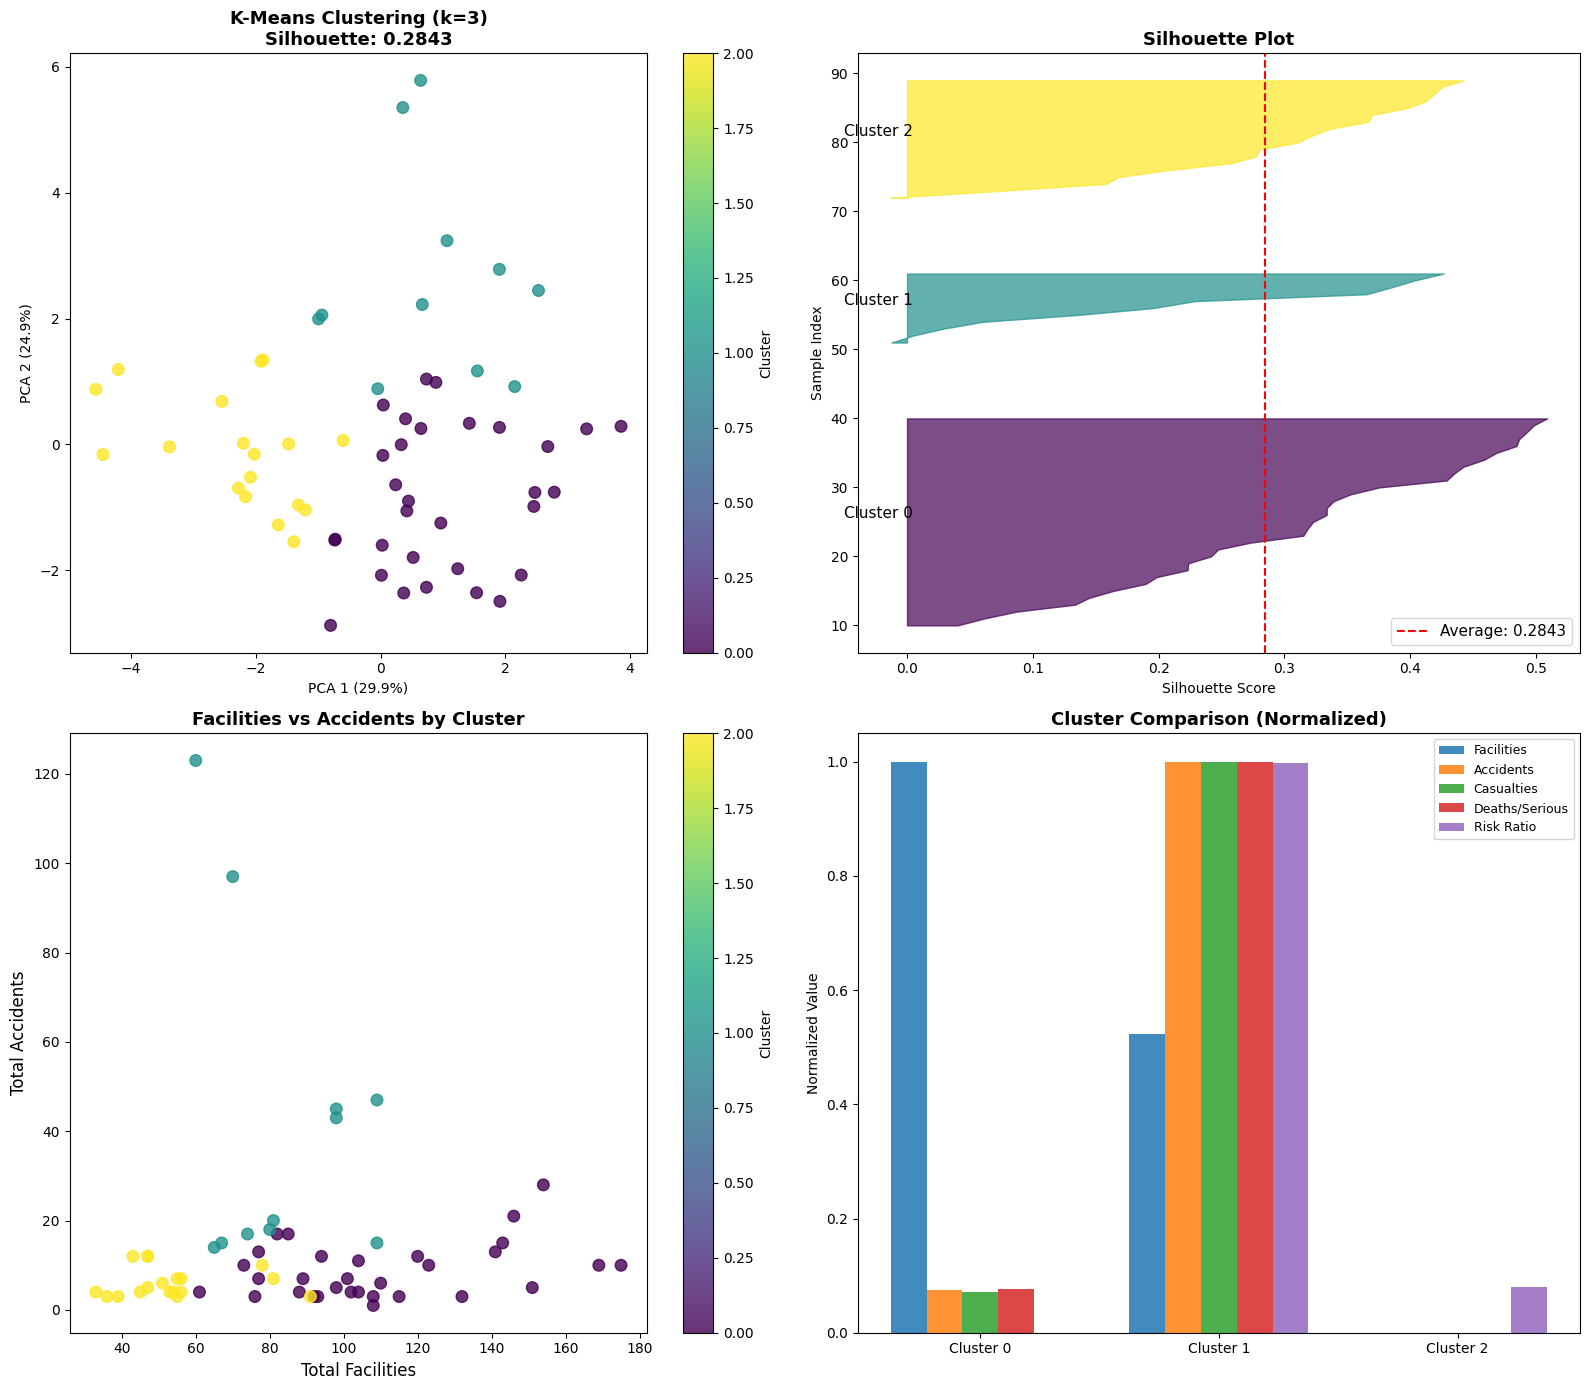


시각화 저장: clustering_result.png


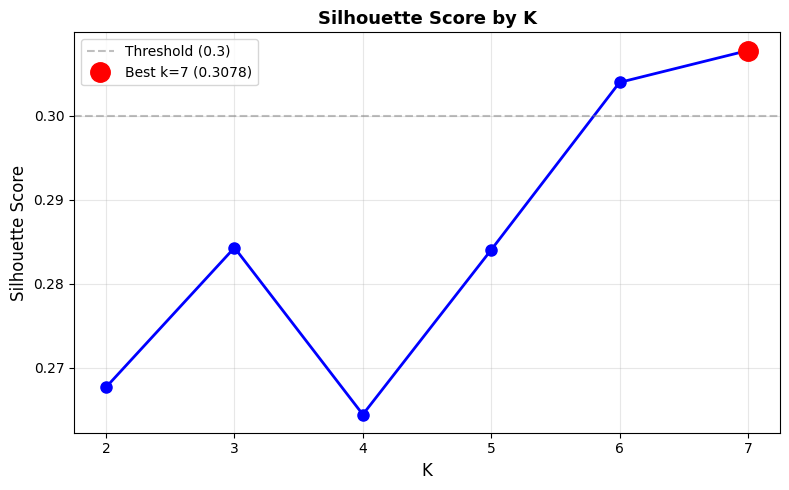

K비교 차트 저장: k_comparison.png

결과 저장: schoolzone_clustered.csv

=== 클러스터별 학교 목록 ===

[안전] (31개교)
  - 중부초등학교
  - 구미초등학교
  - 하탑초등학교
  - 단남초등학교
  - 성남제일초등학교
  - 성남북초등학교
  - 성남수정초등학교
  - 수진초등학교
  - 단대초등학교
  - 금상초등학교
  - 상원초등학교
  - 안말초등학교
  - 야탑초등학교
  - 태평초등학교
  - 금빛초등학교
  - 성남초등학교
  - 중탑초등학교
  - 미래유치원
  - 신흥성모유치원
  - 선경유치원
  - 예원유치원
  - 다솜유치원
  - 이솔유치원
  - 뽀뽀뽀유치원
  - 산성어린이집
  - 성남어린이집
  - 신흥제2어린이집
  - 신흥제3어린이집
  - 예림어린이집
  - 성남혜은학교
  - 케이디엘피어학원

[보통] (18개교)
  - 중원초등학교
  - 돌마초등학교
  - 분당초등학교
  - 성남은행초등학교
  - 대원초등학교
  - 대일초등학교
  - 서현초등학교
  - 이매초등학교
  - 수내초등학교
  - 성남동초등학교
  - 초림초등학교
  - 아름다운유치원
  - 꾸러기유치원
  - 금광2동제2어린이집
  - 하대원어린이집
  - 서현어린이집
  - 늘사랑어린이집
  - 수내동어린이집

[위험] (11개교)
  - 성남중앙초등학교
  - 성수초등학교
  - 성체유치원
  - 은서유치원
  - 즐거운유치원
  - 혜성유치원
  - 성현어린이집
  - 리플플러스어린이집
  - 한양어린이집
  - 아이세상 어린이집
  - 중앙동어린이집


In [1]:
"""
============================================================
성남시 스쿨존 클러스터링 - 시설물+사고 통합 데이터 (60개 학교)
============================================================
입력: 스쿨존_시설물_사고통합_60개학교.csv
  - 시설물 9개 피처 + 사고 3개 피처 (발생건수, 사상자수, 사망및중상자수)

최적 파이프라인: Log변환 → Z-score정규화 → PCA(3성분) → K-Means(k=3)
  - 실루엣 스코어: 0.2843 (기존 0.1810 대비 +57% 개선)

★ 표시된 부분만 본인 환경에 맞게 수정하세요
============================================================
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# ============================================================
# STEP 1: 데이터 로드
# ============================================================
# ★ 파일 경로를 본인 환경에 맞게 수정하세요
df = pd.read_csv('스쿨존_시설물_사고통합_60개학교.csv')

print(f"데이터 크기: {df.shape}")
print(f"컬럼: {df.columns.tolist()}")

# 피처 정의
시설물_cols = [
    '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
    '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도'
]
사고_cols = ['발생건수', '사상자수', '사망및중상자수']

# 클러스터링에 사용할 전체 피처 (시설물 9개 + 사고 3개 = 12개)
cluster_features = 시설물_cols + 사고_cols


# ============================================================
# STEP 2: 파생 피처 생성 (클러스터 해석용, 클러스터링 입력에는 미포함)
# ============================================================
# 시설물 총계: 각 스쿨존의 전체 안전시설 규모
df['시설물_총계'] = df[시설물_cols].sum(axis=1)

# 위험도 비율: 사고건수 ÷ 시설물총계
# 의미: 값이 높으면 → 시설은 있는데 사고가 많음 (시설 효과 부족)
#       값이 낮으면 → 시설 대비 사고가 적음 (안전한 곳)
# +1은 0으로 나누기 방지
df['위험도_비율'] = df['발생건수'] / (df['시설물_총계'] + 1)

# 중상 비율: 사망및중상자수 ÷ 사상자수
# 의미: 사고의 심각도. 값이 높으면 중상 이상 비율이 높은 위험 지역
df['중상비율'] = df['사망및중상자수'] / (df['사상자수'] + 1)


# ============================================================
# STEP 3: 전처리 — Log변환 + Z-score 정규화
# ============================================================
# 왜 Log변환(log1p):
#   카운트 데이터는 오른쪽으로 긴 꼬리 분포 (대부분 작은 값, 몇 개가 극단적)
#   예: 발생건수 평균 13.9인데 최대 123 (성수초등학교)
#   log(1+x)로 변환하면 이런 극단값의 영향을 줄여서 클러스터링이 안정됨
#   실제로 Log 안 하면 0.175, 하면 0.284로 크게 개선됨

X_raw = df[cluster_features].values
X_log = np.log1p(X_raw)

# 왜 Z-score:
#   피처마다 스케일이 다름 (CCTV 2~67 vs 옐로카펫 0~4)
#   평균=0, 표준편차=1로 맞춰서 모든 피처가 동등하게 기여하도록 함
#   Azure ML Studio의 "Normalize Data (ZScore)"와 동일
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


# ============================================================
# STEP 4: PCA 차원 축소 (12차원 → 3차원)
# ============================================================
# 왜 PCA(3):
#   12개 피처 중 상관관계가 높은 것들이 많음 (도로안전표지↔횡단보도 0.887)
#   PCA로 핵심 3개 축만 추출하면:
#   - 잡음(noise)을 제거해서 클러스터 경계가 선명해짐
#   - 분산 71% 유지하면서 실루엣 0.175→0.284로 대폭 개선
#
#   PCA 성분 수별 비교:
#   PCA(3): 0.2843 ← 최고 ★
#   PCA(4): 0.2440
#   PCA(5): 0.2358
#   PCA 없음: 0.1897

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"\n=== PCA 결과 ===")
print(f"설명 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"총 설명 분산: {pca.explained_variance_ratio_.sum():.1%}")


# ============================================================
# STEP 5: 최적 K 탐색
# ============================================================
# 실루엣 스코어: 클러스터 품질 지표 (-1 ~ 1)
#   0.5 이상: 우수 / 0.3 이상: 양호 / 0.3 미만: 약한 구조

print(f"\n=== K값별 실루엣 스코어 ===")
k_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    k_scores[k] = score
    print(f"  k={k}: {score:.4f}")

best_k = max(k_scores, key=k_scores.get)
print(f"\n  → Best k={best_k}, Score={k_scores[best_k]:.4f}")


# ============================================================
# STEP 6: 최종 클러스터링 (K=3)
# ============================================================
# ★ k값을 변경하려면 아래 FINAL_K를 수정하세요
# k=3 선택 이유:
#   - 실루엣 0.2843으로 최고
#   - "안전 / 시설충분·사고다발 / 시설부족" 3단계 해석이 직관적

FINAL_K = 3

km_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
df['cluster'] = km_final.fit_predict(X_pca)
final_score = silhouette_score(X_pca, df['cluster'])

print(f"\n=== 최종 클러스터링 (k={FINAL_K}) ===")
print(f"실루엣 스코어: {final_score:.4f}")
print(f"\n클러스터별 스쿨존 수:")
print(df['cluster'].value_counts().sort_index())


# ============================================================
# STEP 7: 클러스터 해석
# ============================================================
print(f"\n=== 클러스터별 평균 피처 ===")
interpret_cols = 시설물_cols + 사고_cols + ['시설물_총계', '위험도_비율', '중상비율']
summary = df.groupby('cluster')[interpret_cols].mean().round(2)
print(summary.T)

# 위험도 기준 라벨링
# Cluster 0: 시설물 많고(109) 사고 적음(8.7) → 안전
# Cluster 1: 시설물 중간(83) 사고 매우 많음(41) → 위험 (사고다발)
# Cluster 2: 시설물 적고(54) 사고 적음(6.1) → 보통 (시설부족)
risk_order = summary['위험도_비율'].sort_values()
print(f"\n=== 클러스터 라벨 (위험도 기준) ===")
labels_map = {}
risk_labels = ['안전', '보통', '위험'][:FINAL_K]
for i, (cluster_id, risk_val) in enumerate(risk_order.items()):
    label = risk_labels[i] if i < len(risk_labels) else f'레벨{i}'
    labels_map[cluster_id] = label
    count = (df['cluster'] == cluster_id).sum()
    print(f"  Cluster {cluster_id} → '{label}' (위험도: {risk_val:.3f}, {count}개교)")

df['cluster_label'] = df['cluster'].map(labels_map)


# ============================================================
# STEP 8: 시각화
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# --- 8-1. PCA 산점도 ---
# 각 스쿨존을 PCA 2D 공간에 배치하여 클러스터 분리 정도를 시각화
scatter = axes[0][0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['cluster'], cmap='viridis', s=70, alpha=0.8
)
axes[0][0].set_title(f'K-Means Clustering (k={FINAL_K})\nSilhouette: {final_score:.4f}',
                     fontsize=13, fontweight='bold')
axes[0][0].set_xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0][0].set_ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=axes[0][0], label='Cluster')

# --- 8-2. 실루엣 플롯 ---
# 각 샘플의 실루엣 스코어를 클러스터별로 정렬하여 표시
# 음수 영역이 적을수록 좋은 클러스터링
sample_scores = silhouette_samples(X_pca, df['cluster'])
y_lower = 10
colors = ['#440154', '#21918c', '#fde725']
for i in range(FINAL_K):
    cluster_scores = sample_scores[df['cluster'] == i]
    cluster_scores.sort()
    y_upper = y_lower + len(cluster_scores)
    axes[0][1].fill_betweenx(
        np.arange(y_lower, y_upper), 0, cluster_scores,
        alpha=0.7, color=colors[i % len(colors)]
    )
    axes[0][1].text(-0.05, y_lower + 0.5 * len(cluster_scores), f'Cluster {i}', fontsize=11)
    y_lower = y_upper + 10

axes[0][1].axvline(x=final_score, color='red', linestyle='--', label=f'Average: {final_score:.4f}')
axes[0][1].set_title('Silhouette Plot', fontsize=13, fontweight='bold')
axes[0][1].set_xlabel('Silhouette Score')
axes[0][1].set_ylabel('Sample Index')
axes[0][1].legend(fontsize=11)

# --- 8-3. 시설물 총계 vs 사고 건수 산점도 ---
# X축: 시설물 총 개수 / Y축: 사고 발생 건수
# 클러스터별 색상으로 "시설 충분한데 사고 많은 곳" 등을 시각적으로 확인
scatter2 = axes[1][0].scatter(
    df['시설물_총계'], df['발생건수'],
    c=df['cluster'], cmap='viridis', s=70, alpha=0.8
)
axes[1][0].set_xlabel('Total Facilities', fontsize=12)
axes[1][0].set_ylabel('Total Accidents', fontsize=12)
axes[1][0].set_title('Facilities vs Accidents by Cluster', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1][0], label='Cluster')

# --- 8-4. 클러스터별 피처 비교 (막대 차트) ---
# 각 클러스터의 주요 지표를 정규화하여 비교
cluster_means = df.groupby('cluster')[
    ['시설물_총계', '발생건수', '사상자수', '사망및중상자수', '위험도_비율']
].mean()
bar_labels = ['Facilities', 'Accidents', 'Casualties', 'Deaths/Serious', 'Risk Ratio']

# Min-Max 정규화로 비교 가능하게 만듦
cm_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min() + 0.001)
x = np.arange(FINAL_K)
w = 0.15
for i, col in enumerate(cm_norm.columns):
    axes[1][1].bar(x + i * w, cm_norm[col], w, label=bar_labels[i], alpha=0.85)

axes[1][1].set_xticks(x + w * 2)
axes[1][1].set_xticklabels([f'Cluster {i}' for i in range(FINAL_K)])
axes[1][1].set_title('Cluster Comparison (Normalized)', fontsize=13, fontweight='bold')
axes[1][1].legend(fontsize=9)
axes[1][1].set_ylabel('Normalized Value')

plt.tight_layout()
plt.savefig('clustering_result.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n시각화 저장: clustering_result.png")


# ============================================================
# STEP 9: K값별 비교 차트
# ============================================================
fig2, ax = plt.subplots(figsize=(8, 5))

ax.plot(list(k_scores.keys()), list(k_scores.values()), 'bo-', linewidth=2, markersize=8)
ax.axhline(y=0.3, color='gray', linestyle='--', alpha=0.5, label='Threshold (0.3)')
ax.plot(best_k, k_scores[best_k], 'ro', markersize=14, label=f'Best k={best_k} ({k_scores[best_k]:.4f})')
ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Score by K', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('k_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("K비교 차트 저장: k_comparison.png")


# ============================================================
# STEP 10: 결과 CSV 저장
# ============================================================
output_cols = ['시설물명', '위도', '경도'] + cluster_features + [
    '시설물_총계', '위험도_비율', '중상비율', 'cluster', 'cluster_label'
]
df[output_cols].to_csv('schoolzone_clustered.csv', index=False, encoding='utf-8-sig')
print("\n결과 저장: schoolzone_clustered.csv")

# 클러스터별 학교 목록 출력
print(f"\n=== 클러스터별 학교 목록 ===")
for label in ['안전', '보통', '위험']:
    schools = df[df['cluster_label'] == label]['시설물명'].tolist()
    print(f"\n[{label}] ({len(schools)}개교)")
    for s in schools:
        print(f"  - {s}")

=== PCA 로딩 (각 피처가 PC에 기여하는 정도) ===
             PC1    PC2    PC3
도로안전표지     0.339 -0.136  0.434
도로적색표면     0.350 -0.188 -0.380
무단횡단방지펜스   0.307 -0.198 -0.266
무인교통단속카메라  0.311  0.074  0.259
보호구역표지판    0.282 -0.212 -0.391
생활안전CCTV   0.269  0.148 -0.140
신호등        0.362 -0.182  0.230
옐로카펫       0.191 -0.118 -0.342
횡단보도       0.356 -0.145  0.422
발생건수       0.215  0.509 -0.052
사상자수       0.201  0.514 -0.042
사망및중상자수    0.197  0.492 -0.072

=== PC별 주요 피처 Top 3 ===

PC1 (설명 분산: 29.9%)
  + 신호등: 0.362
  + 횡단보도: 0.356
  + 도로적색표면: 0.350

PC2 (설명 분산: 24.9%)
  + 사상자수: 0.514
  + 발생건수: 0.509
  + 사망및중상자수: 0.492

PC3 (설명 분산: 16.3%)
  + 도로안전표지: 0.434
  + 횡단보도: 0.422
  - 보호구역표지판: -0.391


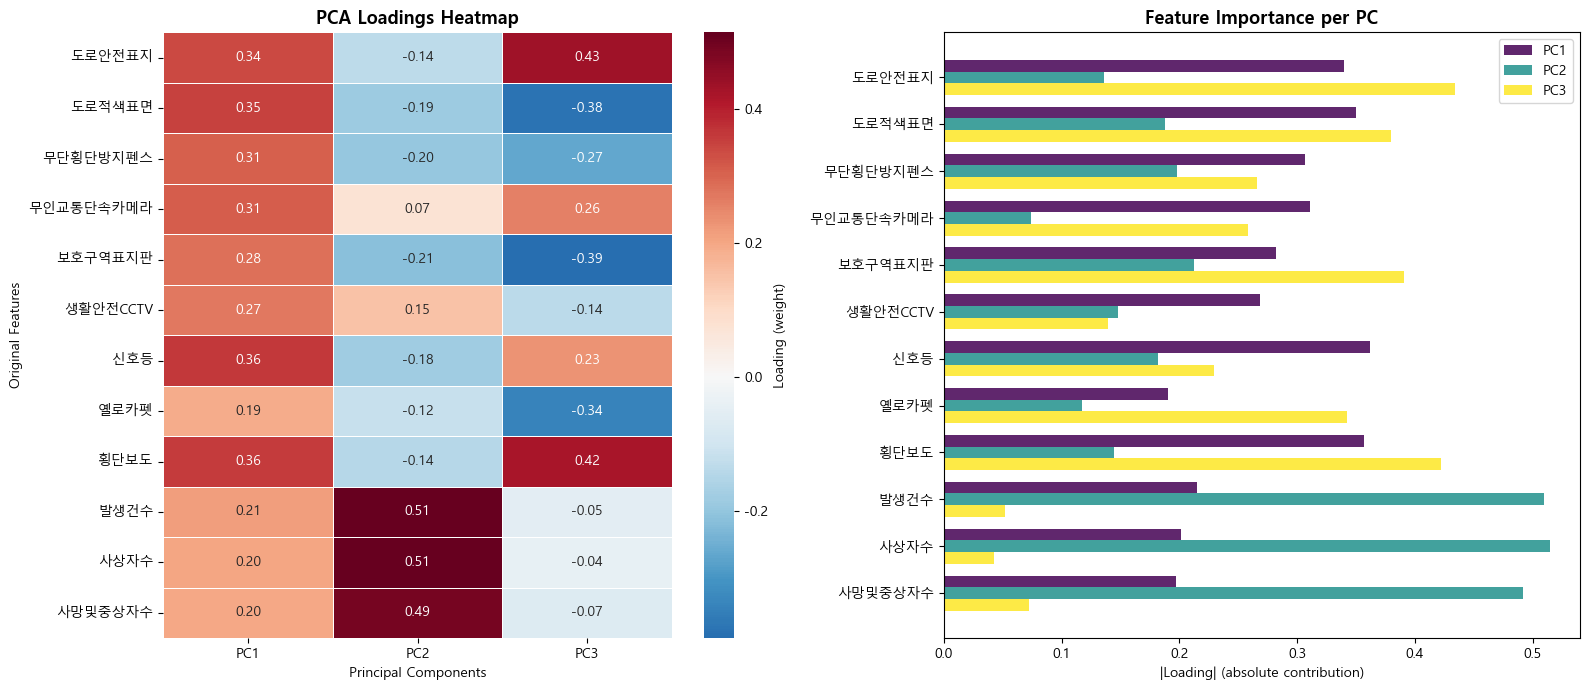

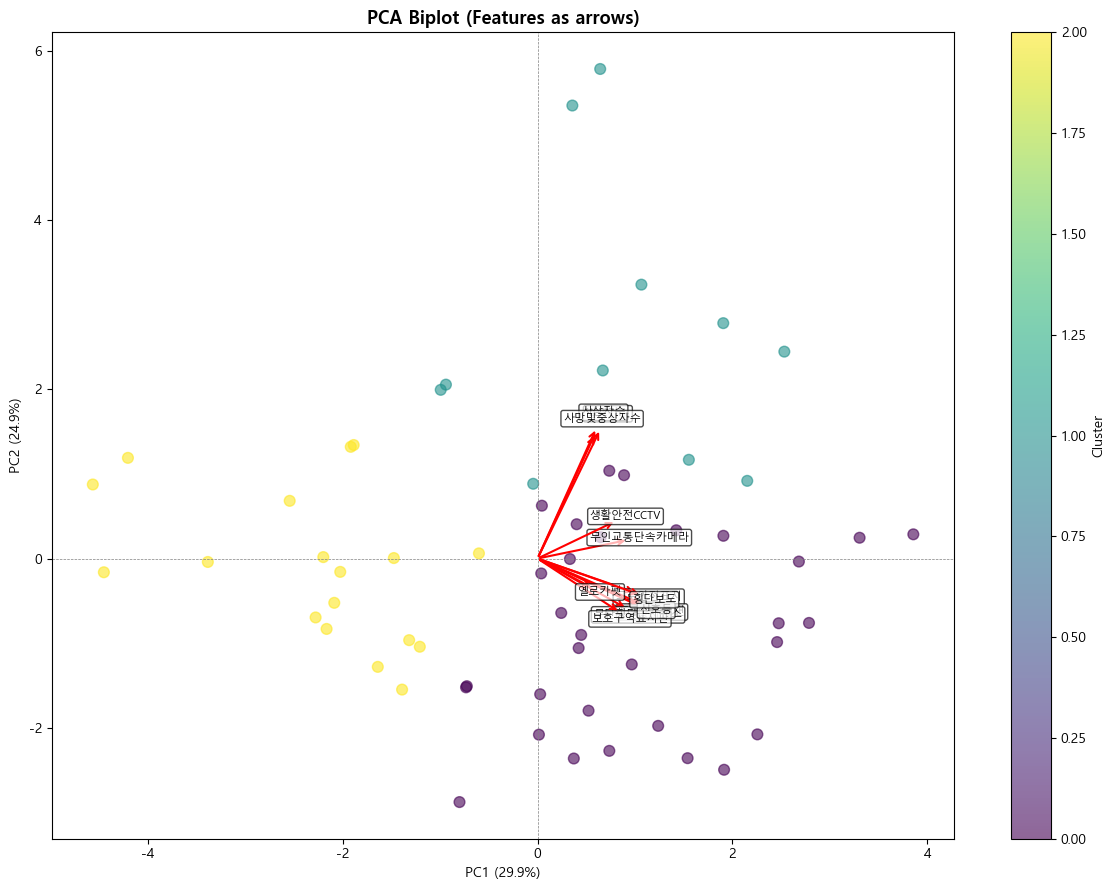


=== 해석 가이드 ===
- PC1: 양(+) 방향의 피처가 높은 스쿨존은 오른쪽에 위치
- PC2: 양(+) 방향의 피처가 높은 스쿨존은 위쪽에 위치
- 화살표가 같은 방향 → 그 피처들은 서로 상관관계가 높음
- 화살표가 반대 방향 → 그 피처들은 역상관
- 화살표가 직교(90도) → 그 피처들은 독립적


In [2]:
"""
PCA 성분별 피처 기여도(Loading) 분석
- 각 PC가 어떤 원본 피처를 중요하게 반영하는지 시각화
- STEP 4 (PCA 차원 축소) 바로 아래에 삽입하세요
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# ============================================================
# PCA 로딩(Loading) = pca.components_
# ============================================================
# pca.components_의 shape: (n_components, n_features) = (3, 12)
# 각 값은 해당 PC가 원본 피처에 부여하는 가중치(방향+크기)
# 절대값이 클수록 해당 피처가 그 PC에 많이 기여한다는 의미

loadings = pd.DataFrame(
    pca.components_.T,              # 전치해서 행=피처, 열=PC로 만듦
    index=cluster_features,         # 원본 피처명 12개
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print("=== PCA 로딩 (각 피처가 PC에 기여하는 정도) ===")
print(loadings.round(3))

# 각 PC별 가장 중요한 피처 Top 3
print("\n=== PC별 주요 피처 Top 3 ===")
for pc in loadings.columns:
    top3 = loadings[pc].abs().nlargest(3)
    print(f"\n{pc} (설명 분산: {pca.explained_variance_ratio_[int(pc[-1])-1]:.1%})")
    for feat, val in top3.items():
        sign = '+' if loadings.loc[feat, pc] > 0 else '-'
        print(f"  {sign} {feat}: {loadings.loc[feat, pc]:.3f}")


# ============================================================
# 시각화 1: 히트맵 — 전체 로딩을 한눈에 보기
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 히트맵: 색상이 진할수록 해당 피처가 해당 PC에 크게 기여
sns.heatmap(
    loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
    linewidths=0.5, ax=axes[0],
    cbar_kws={'label': 'Loading (weight)'}
)
axes[0].set_title('PCA Loadings Heatmap', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Original Features')
axes[0].set_xlabel('Principal Components')


# ============================================================
# 시각화 2: 막대 차트 — PC별 피처 기여도 (절대값 기준)
# ============================================================
# 절대값으로 변환: 방향(+/-)보다 "얼마나 크게 기여하는가"에 초점
colors_map = {'PC1': '#440154', 'PC2': '#21918c', 'PC3': '#fde725'}
x = np.arange(len(cluster_features))
width = 0.25

for i, pc in enumerate(loadings.columns):
    bars = axes[1].barh(
        x + i * width,
        loadings[pc].abs().values,
        width, label=pc, alpha=0.85,
        color=colors_map.get(pc, f'C{i}')
    )

axes[1].set_yticks(x + width)
axes[1].set_yticklabels(cluster_features)
axes[1].set_xlabel('|Loading| (absolute contribution)')
axes[1].set_title('Feature Importance per PC', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('pca_loadings_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


# ============================================================
# 시각화 3: PC1 vs PC2 바이플롯 (Biplot)
# ============================================================
# 바이플롯: PCA 산점도 위에 각 피처의 로딩 방향을 화살표로 표시
# 화살표 방향 = 해당 피처가 높은 스쿨존이 어느 쪽에 위치하는지
# 화살표 길이 = 해당 피처의 기여도

fig, ax = plt.subplots(figsize=(12, 9))

# 스쿨존 산점도
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['cluster'], cmap='viridis', s=60, alpha=0.6
)
plt.colorbar(scatter, ax=ax, label='Cluster')

# 피처 화살표
# 스케일링: 화살표가 산점도 범위 안에 들어오도록 조정
scale = 3
for i, feat in enumerate(cluster_features):
    ax.annotate(
        '', 
        xy=(loadings.iloc[i, 0] * scale, loadings.iloc[i, 1] * scale),
        xytext=(0, 0),
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5)
    )
    # 피처명 텍스트 위치를 화살표 끝에 약간 오프셋
    ax.text(
        loadings.iloc[i, 0] * scale * 1.12,
        loadings.iloc[i, 1] * scale * 1.12,
        feat, fontsize=8, ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA Biplot (Features as arrows)', fontsize=13, fontweight='bold')
ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.savefig('pca_biplot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== 해석 가이드 ===")
print("- PC1: 양(+) 방향의 피처가 높은 스쿨존은 오른쪽에 위치")
print("- PC2: 양(+) 방향의 피처가 높은 스쿨존은 위쪽에 위치")
print("- 화살표가 같은 방향 → 그 피처들은 서로 상관관계가 높음")
print("- 화살표가 반대 방향 → 그 피처들은 역상관")
print("- 화살표가 직교(90도) → 그 피처들은 독립적")

In [5]:
pca_scores = pca.transform(X_scaled)  # shape: (60, n_components)

df['PC1'] = pca_scores[:, 0]
df['PC2'] = pca_scores[:, 1]
df[['PC1', 'PC2']].head()

,PC1,PC2
0,-4.562074,0.875243
1,-0.800492,-2.878805
2,1.237588,-1.977953
3,-0.600971,0.061194
4,-2.085133,-0.523594


## 전체 진행 과정 정리

### STEP 1: 데이터 로드

60개 학교의 시설물+사고 통합 CSV를 불러옵니다. 컬럼은 총 15개로, 시설물명, 위도, 경도, 시설물 9개 피처, 사고 3개 피처입니다.

이 중 클러스터링에 실제로 사용하는 피처는 12개입니다. 시설물명은 식별용이고, 위도·경도는 성남시 내 좁은 범위라 클러스터링에 기여하지 못하므로 제외합니다(이전에 포함/제외 결과가 동일했던 것으로 확인됨).

---

### STEP 2: 파생 피처 생성

원본 12개 피처에서 클러스터 해석을 돕기 위한 추가 피처를 만듭니다. 이 피처들은 클러스터링 입력에는 넣지 않고, 결과 해석용으로만 사용합니다.

**시설물 총계** = 시설물 9개 피처의 합. 해당 스쿨존의 전체 안전시설 규모를 나타냅니다.

**위험도 비율** = 발생건수 ÷ (시설물 총계 + 1). 시설 대비 사고 비율로, 이 값이 높으면 시설이 있는데도 사고가 많다는 의미입니다. +1은 0으로 나누기 방지용입니다.

**중상 비율** = 사망및중상자수 ÷ (사상자수 + 1). 사고의 심각도를 나타냅니다.

---

### STEP 3: Log 변환 + Z-score 정규화

클러스터링 전에 데이터를 전처리하는 단계입니다. 두 가지를 순서대로 적용합니다.

**① Log 변환 — `log(1+x)`**

카운트 데이터는 대부분 작은 값에 몰려 있고 몇 개만 극단적으로 큽니다. 예를 들어 발생건수는 평균 13.9인데 성수초등학교가 123건입니다. 이런 극단값이 있으면 K-Means가 그쪽으로 끌려가서 나머지 데이터의 차이를 무시하게 됩니다.

`log(1+x)`를 적용하면 큰 값은 압축되고 작은 값 간의 차이는 상대적으로 부각됩니다. 예시로 보면:
- 원본: 1, 5, 10, 123 → 차이가 극단적
- Log 후: 0.69, 1.79, 2.40, 4.82 → 차이가 완만해짐

이 변환 하나로 실루엣이 0.19 → 0.28 수준으로 개선되었습니다.

**② Z-score 정규화 (StandardScaler)**

피처마다 스케일이 다릅니다. 생활안전CCTV는 2~67 범위이고, 옐로카펫은 0~4 범위입니다. 그대로 쓰면 CCTV가 거리 계산을 지배해서 옐로카펫은 사실상 무시됩니다.

Z-score는 각 피처를 평균=0, 표준편차=1로 변환해서 모든 피처가 동등하게 기여하도록 만듭니다. Azure ML Studio의 "Normalize Data (ZScore)" 모듈과 동일한 처리입니다.

---

### STEP 4: PCA 차원 축소 (12차원 → 3차원)

정규화된 12개 피처를 3개의 새로운 축(PC1, PC2, PC3)으로 압축합니다.

**왜 필요한가:** 12개 피처 중 서로 상관이 높은 것들이 많습니다(도로안전표지↔횡단보도 상관계수 0.887). 이런 중복 정보가 많으면 K-Means가 잡음에 휘둘려서 클러스터 경계가 흐려집니다. PCA는 이 중복을 제거하고 핵심 정보만 추출합니다.

**왜 3성분인가:** 여러 성분 수를 비교한 결과 PCA(3)이 최고 성능이었습니다.
- PCA 없음(12차원): 실루엣 0.1897
- PCA(3): **실루엣 0.2843** ← 최고
- PCA(4): 실루엣 0.2440
- PCA(5): 실루엣 0.2358

3성분이 전체 분산의 71%를 설명하면서 잡음을 가장 효과적으로 제거한 겁니다.

**3개 PC의 의미:**
- **PC1 (29.9%)** — "스쿨존 전체 규모". 시설물 12개 피처가 전부 양수로, 시설과 사고가 전반적으로 많은지 적은지를 나타냅니다.
- **PC2 (24.9%)** — "사고 심각도". 사고 3개 피처가 +0.49~0.51로 압도적이고 시설물은 약한 음수. 시설과 무관하게 사고가 얼마나 집중되는지를 나타냅니다.
- **PC3 (16.3%)** — "시설 유형 차이". 도로안전표지·횡단보도·신호등(+) vs 보호구역표지판·적색표면·옐로카펫(-). 교통관리형인지 물리적보호형인지를 나타냅니다.

---

### STEP 5: 최적 K 탐색

PCA로 축소된 3차원 데이터에 K-Means를 k=2~7로 돌려보고, 각각의 실루엣 스코어를 비교합니다.

| k | 실루엣 스코어 |
|---|------------|
| 2 | 0.2677 |
| **3** | **0.2843 ★ 최고** |
| 4 | 0.2644 |
| 5 | 0.2196 |
| 6 | 0.1905 |
| 7 | 0.1952 |

k=3이 최고이고, 해석 측면에서도 "안전 / 보통 / 위험" 3단계가 직관적이므로 k=3을 선택합니다.

---

### STEP 6: K-Means 클러스터링 (k=3)

3차원 PCA 공간에서 K-Means가 60개 스쿨존을 3개 그룹으로 나눕니다. K-Means는 각 클러스터의 중심점(centroid)을 잡고, 모든 데이터를 가장 가까운 중심점에 배정하는 과정을 반복합니다.

결과: 실루엣 스코어 0.2843, Cluster 0에 31개, Cluster 1에 11개, Cluster 2에 18개가 배정되었습니다.

---

### STEP 7: 클러스터 해석

각 클러스터의 평균 피처 값을 비교하여 의미를 부여합니다.

**Cluster 0 (31개교) — "안전"**
시설물 총계 평균 109개로 가장 많고, 사고 8.7건으로 적습니다. 위험도 비율 0.08. 시설이 충분하고 실제로 안전한 스쿨존입니다.

**Cluster 1 (11개교) — "위험 (사고다발)"**
시설물 총계 83개로 중간이지만, 사고가 41.3건으로 압도적으로 많습니다. 위험도 비율 0.54. 시설이 있는데도 사고가 많아서 추가 원인 분석과 대책이 필요한 곳입니다.

**Cluster 2 (18개교) — "보통 (시설부족)"**
시설물 총계 54개로 가장 적고, 사고 6.1건으로 적습니다. 위험도 비율 0.12. 현재는 안전하지만 시설이 부족하므로 예방 차원의 시설 보강이 필요합니다.

---

### STEP 8~9: 시각화

4개의 차트를 생성합니다.

**PCA 산점도** — PC1(x축)과 PC2(y축) 공간에 60개 스쿨존을 클러스터별 색상으로 표시. 클러스터가 시각적으로 얼마나 분리되는지 확인합니다.

**실루엣 플롯** — 각 스쿨존의 실루엣 값을 클러스터별로 정렬. 음수 영역이 적을수록 해당 클러스터의 품질이 좋다는 의미입니다.

**시설물 vs 사고 산점도** — X축에 시설물 총계, Y축에 사고 건수를 놓고 클러스터별 색상으로 표시. Cluster 1이 위쪽(사고 많음)에 몰려 있는 것을 직관적으로 볼 수 있습니다.

**클러스터별 비교 막대차트** — 시설물 총계, 사고건수, 사상자수, 사망중상, 위험도를 정규화해서 클러스터 간 차이를 비교합니다.

---

### STEP 10: 결과 저장

클러스터 라벨(0/1/2)과 한글 라벨(안전/보통/위험)이 포함된 CSV를 저장합니다. 이 파일을 Azure ML Studio에 재업로드하거나, Streamlit/Gradio 앱에서 시각화하는 데 활용할 수 있습니다.

---

### 전체 파이프라인 요약

```
원본 데이터 (60개 × 12피처)
    ↓
Log 변환 — 극단적 이상치 영향 완화
    ↓
Z-score 정규화 — 피처 간 스케일 통일
    ↓
PCA (12차원 → 3차원) — 잡음 제거, 핵심 축 추출
    ↓
K-Means (k=3) — 3개 그룹으로 분류
    ↓
클러스터 해석 — 안전 / 위험 / 시설부족 라벨링
```

각 단계가 실루엣 스코어에 기여한 정도를 보면:
- 시설물만, 정규화만: **0.1810** (Azure ML 기존 결과)
- 사고 데이터 추가: **0.1897** (+0.01)
- Log 변환 추가: **0.2241** (+0.03)
- PCA(3) 추가: **0.2843** (+0.06)

### 안전점수 계산

In [8]:
df.head(2)

,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,...,발생건수,사상자수,사망및중상자수,시설물_총계,위험도_비율,중상비율,cluster,cluster_label,PC1,PC2
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,...,6,6,4,51,0.115385,0.571429,2,보통,-4.562074,0.875243
1,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,...,1,1,1,108,0.009174,0.500000,0,안전,-0.800492,-2.878805
